# 🎯 Uplift model selection

#  [MegaFon Uplift Competition](https://ods.ai/competitions/megafon-df21-comp)

## problem: predict the uplift by user's feature vector

In [1]:
pip install scikit-uplift lightgbm -U

In [2]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV, 
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer

In [3]:
dataset = fetch_megafon()
data, treatment, target = dataset.data, dataset.treatment, dataset.target
data = data.set_index('id')

data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
id,,,,,,,,,,,,,,,,,,,,,
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858


In [4]:
treatment.head()

0      control
1      control
2    treatment
3    treatment
4    treatment
Name: treatment_group, dtype: object

In [5]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: conversion, dtype: int64

---

# 📝Solution of problem

In [6]:
# make treatment binary
treatment = treatment.map({'control': 0, 'treatment': 1})

### 1) Conditional Independence Assumption:

intuition: check if treatment was random

In [7]:
f1_micro = cross_val_score(
    X=data,
    y=treatment,
    estimator= LGBMClassifier(random_state=42, n_jobs=-1),
    scoring='f1_micro', 
    cv=3)

print(f'F1 micro {f1_micro.mean():.2f}')

F1 micro 0.50


Based on the user's features, the classifier makes type I and type II errors as often (50%) as it guesses the correct answer. This means that communication was carried out by random.

### 2) Fit single model with treatment feature (S-Learner approach) ([link to tutorial](https://habr.com/ru/company/ru_mts/blog/485980/))

intuition: the model fits simultaneously on two groups with binary treatment flag as an additional user's feature. We score each object from the test sample twice: with the treatment flag equal to 1 and equal to 0. Subtracting the probabilities for each observation, we obtain an estimated uplift.

In [8]:
# setting up data
# use test set for model evaluation after grid-search-cross-validation-tuning 
# use cv set for GridSearchCV

stratify_cols = pd.concat([treatment, target], axis=1)

X_cv, X_test, y_cv, y_test, trmnt_cv, trmnt_test = train_test_split(
    data,
    target,
    treatment,
    stratify=stratify_cols,
    test_size=0.2,
    random_state=42
)

In [9]:
# setting up model ...
estimator = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
)

# ... metamodel ...
slearner = SoloModel(estimator=estimator)

# ... and uplift metric scorer to pass to cross validation
uplift_scorer = make_uplift_scorer("qini_auc_score", trmnt_cv)

In [10]:
cv_gen = StratifiedShuffleSplit(
    n_splits=3,
    random_state=42
)

cross_validate(slearner,    
               X=X_cv,
               y=y_cv,
               scoring=uplift_scorer,
               return_estimator=True,
               cv=cv_gen,
               n_jobs=-1,
               fit_params={'treatment': trmnt_cv}
)

{'fit_time': array([33.87235594, 33.96732211, 33.46848416]),
 'score_time': array([1.76540208, 1.70858002, 1.79931688]),
 'estimator': [SoloModel(estimator=LGBMClassifier(random_state=42)),
  SoloModel(estimator=LGBMClassifier(random_state=42)),
  SoloModel(estimator=LGBMClassifier(random_state=42))],
 'test_score': array([0.22895519, 0.22294613, 0.22625875])}

In [11]:
grid = {
    'estimator__learning_rate': [0.2],
    'estimator__max_depth': [6]
}

grid_search = GridSearchCV(slearner,
                           param_grid=grid,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(
    X=X_cv,
    y=y_cv,
    treatment=trmnt_cv
)

In [12]:
print(f"best qini score on grid search: {grid_search.best_score_:.4f}")
print(f"best params: {grid_search.best_params_}")

best qini score on grid search: 0.2269
best params: {'estimator__learning_rate': 0.2, 'estimator__max_depth': 6}


In [13]:
slearner.set_params(**grid_search.best_params_)

slearner.fit(
    X=X_cv, 
    y=y_cv, 
    treatment=trmnt_cv,
)

uplift = slearner.predict(X_test)

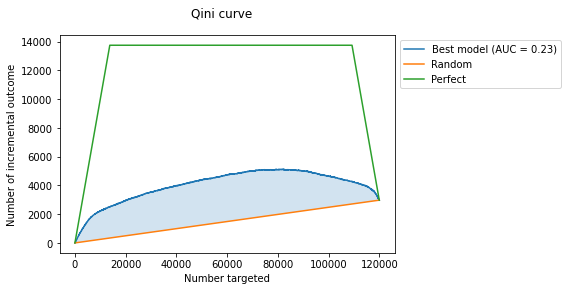

In [14]:
bets_disp = plot_qini_curve(y_test, uplift, trmnt_test, perfect=True, name='Best model');
bets_disp.figure_.suptitle("Qini curve");